# Categorising country development by K-means

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [92]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [93]:
# Random state seed
rseed = 42

# Setting the stying of the Seaborn figure
sns.set_style('darkgrid')

### Functions

In [94]:
def correlation_heatmap(data, col_ls, figx=8, figy=8):
    '''
    This function calculates the correlation matrix for dataframe 'data' and
    displays the result in a triangle heatmap, without the diagonal [1]. The
    heatmap is coloured -1 = Blue, 0 = White and +1 = Red.
    Parameters:
        data = the dataframe
        col_ls = list of columns to include in the heatmap
        figx, figy = the size of the figure (default values 8, 8)
    Returns:
        corr_X: correlation matrix
    Notes:
        Run col_ls = data.columns.tolist() first to include all the columns
    Reference:
        [1] https://www.geeksforgeeks.org/python/how-to-create-a-triangle-correlation-heatmap-in-seaborn-python/
    '''
    # Prepare the data
    X = data[col_ls]

    # Calculate the correlation matrix
    corr_X = X.corr(numeric_only=True)

    # Prepare the figure
    fig = plt.figure(figsize=(figx, figy))

    # Create mask
    mask = np.triu(np.ones_like(corr_X))

    # Create the heatmap
    sns.set_style(style='white')
    sns.heatmap(
        corr_X, cmap="RdBu_r", annot=True,
        vmin=-1, vmax=1,
        square=True, mask=mask
    )

    return corr_X

In [95]:
def features_in_scatter_plots(df, y, color="cornflowerblue"):
    '''
    Plots all the independent variables against a target variable.
    Parameters:
        df = DataFrame
        y = target variable, present in df, as string
        color = display color, default cornflower blue
    Output:
        Displays a grid of scatter plots.
    '''
    # Prepare figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Find target index
    target_index = df.columns.get_loc(y)

    # Customize column indices to iterate over
    if target_index == 0:
        col_index = 1
    else:
        col_index = 0

    # Loop to create scatter plots
    for i in range(2):
        for j in range(4):
            # Create scatter plot for the required variables
            if col_index != target_index:  # Skip the target index
                x_var = df.columns[col_index]
                sns.scatterplot(
                    data=df, x=x_var, y=y, ax=axes[i, j], s=4, color=color
                )
                axes[i, j].set_title(f"Distribution of {x_var} and {y}")
            col_index += 1

    plt.tight_layout()

In [96]:
def pair_plot(df, figx=10, figy=10):
    '''
    Create a seaborn pair plot from a dataframe. The pair plot shows scatter
    plots in the upper triangle, histograms on the diagonal and kde plots in the
    lower triangle.
    Parameters:
        df = dataframe
        figx, figy = figure size, default 10,10
    '''

    # Prepare figure
    fig=plt.figure(figsize=(figx,figy))

    # Create pair grid
    g = sns.PairGrid(df)

    # Customise displayed data to show scatter plots in the upper triangle,
    # histograms on the diagonal and kde plots in the lower triangle
    g.map_upper(plt.scatter, color = "mediumseagreen", s=4)
    g.map_lower(sns.kdeplot, cmap = "viridis_r", fill=True)
    g.map_diag(sns.histplot, color = "indigo")

    return

In [97]:
def eval_Kmeans(x, k, r):
    """
    Evaluates the KMeans clustering for a given number of clusters (k)
    and random seed (r), returning the inertia (sum of squared distances
    of samples to their closest cluster center).

    Parameters:
    - x: Data to be clustered.
    - k: Number of clusters.
    - r: Random state for reproducibility.

    Returns:
    - inertia: Sum of squared distances within clusters.
    """
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

In [98]:
def elbow_Kmeans(x, max_k=10, r=42):
    """
    Plots the inertia (within-cluster variance) against the number of
    clusters to help determine the optimal number of clusters (the 'elbow').

    Parameters:
    - x: Data to be clustered.
    - max_k: Maximum number of clusters to evaluate (default is 10).
    - r: Random state for reproducibility (default is 123).
    """
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')

In [99]:
def visualise_clusters(df, x, y, xlabel, ylabel, hue="Cluster_label", ax=None):
    '''
    Visualise the clusters on a scatter plot.
    Parameters:
        df = DataFrame
        x = column in df to plot on x-axis as string
        y = column in df to plot on y-axis as string
        xlabel = x-axis title as string
        ylabel = y-axis title as string
        hue = column in df to use to specify clusters, default "Cluster_label"
        ax = matplotlib axes object, if None creates new figure (default)
    Output:
        Displays the scatter plot.
    '''
    # Prepare figure if no axes provided
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()

    # Create plot
    sns.scatterplot(data=df, x=x, y=y, hue=hue, palette="Dark2", ax=ax)

    # Add labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title="Cluster")

## Load and explore data

In [100]:
# Import the dataset
df_all = pd.read_csv("Country-data.csv")

In [101]:
# Check the shape
df_all.shape

(167, 10)

In [102]:
# Check datatypes & counts
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [103]:
# Get descriptive statistics
print(df_all.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [104]:
# Identify any missing data
print(df_all.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


There are 167 complete rows of data with entries in 10 columns. The dataset is complete and ready for preprocessing.

## Preprocessing and Feature Selection

In [105]:
# Drop any non-numeric features (columns)
non_numeric_cols = df_all.select_dtypes(include=['object']).columns.tolist()

df = df_all.drop(columns=non_numeric_cols, axis=1).copy()

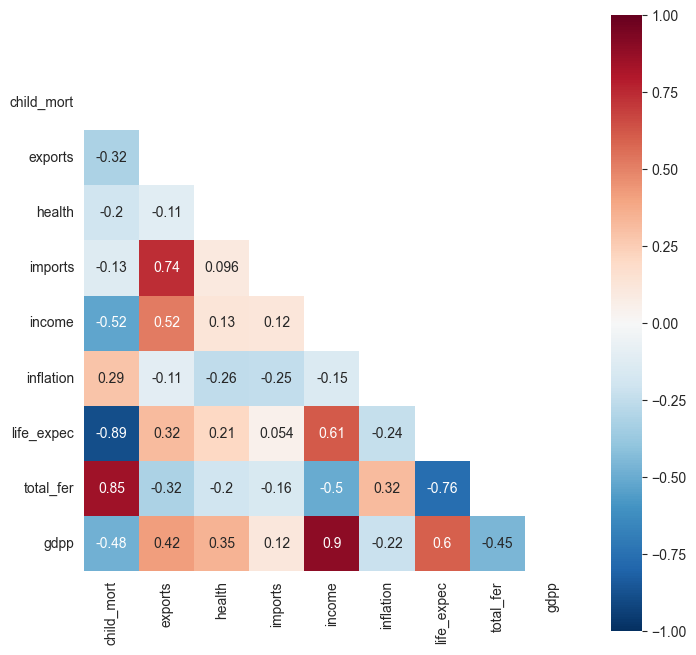

In [106]:
# Create a correlation map of features to explore relationships between features
col_ls = df.columns.tolist()
corr_X = correlation_heatmap(df, col_ls)

The deeper hues in the heatmap indicate stronger positive (red) and negative (blue) correlations between variables. White and very pale shades indicate a null correlation between variables.

There are strong positive correlations between:
* child_mort and total_fer
* exports and income, imports
* income and gdpp, life_expec
* life_expec and gdpp.

The strong positive correlations indicate:
* the number of children in families increases as child mortality under 5 increases
* as country prosperity increases (exports), imports and income also increase
* by definition, income increases as GDP per person increases
* life expectancy increases as income, and hence GDP per person increases.

There are strong negative correlations between:
* child_mort and life_expec, income
* income and total_fer
* life_expc and total_fer

The strong negative correlations indicate:
* where the child mortality rate is high, life expectancy and income are low
* where the income is low, the number of children in families is high
* where life expectancy is low, the number of children in families is high.

Imports and inflation are weakly related to the other variables.

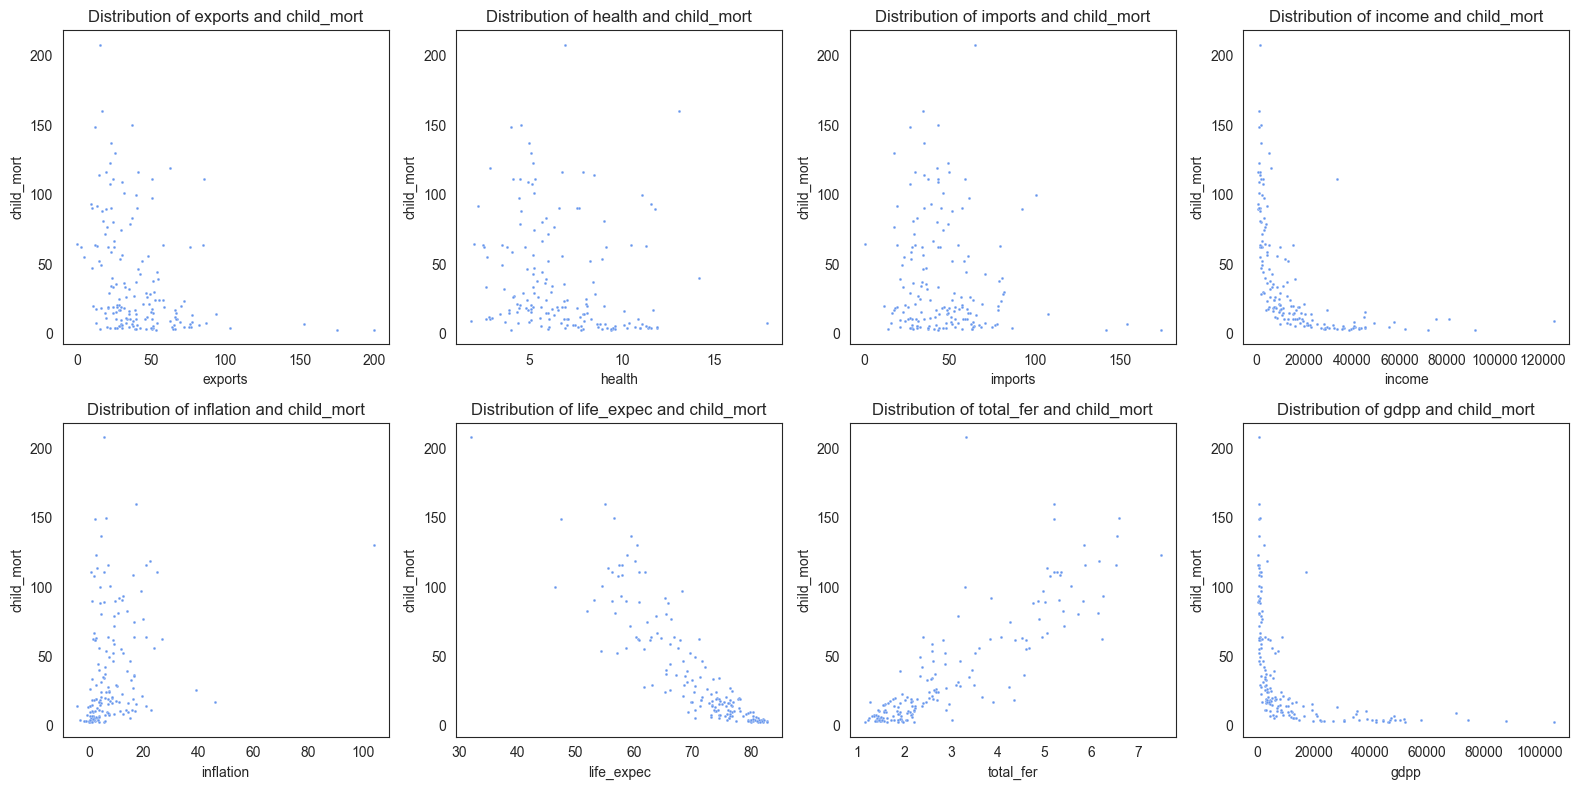

In [107]:
# Explore the continuous independent features against child_mort using scatter
# plots.
features_in_scatter_plots(df, "child_mort")

The distributions of income and gdpp are very similar in shape, and the heatmap also found a relationship between them. 

The distributions of inflation, imports and exports are very similar in shape, and the heatmap found a relationship between them.

The distribution of life_expec shows a linear decreasing trend, while the distribution of total_fer shows a linear increasing trend.

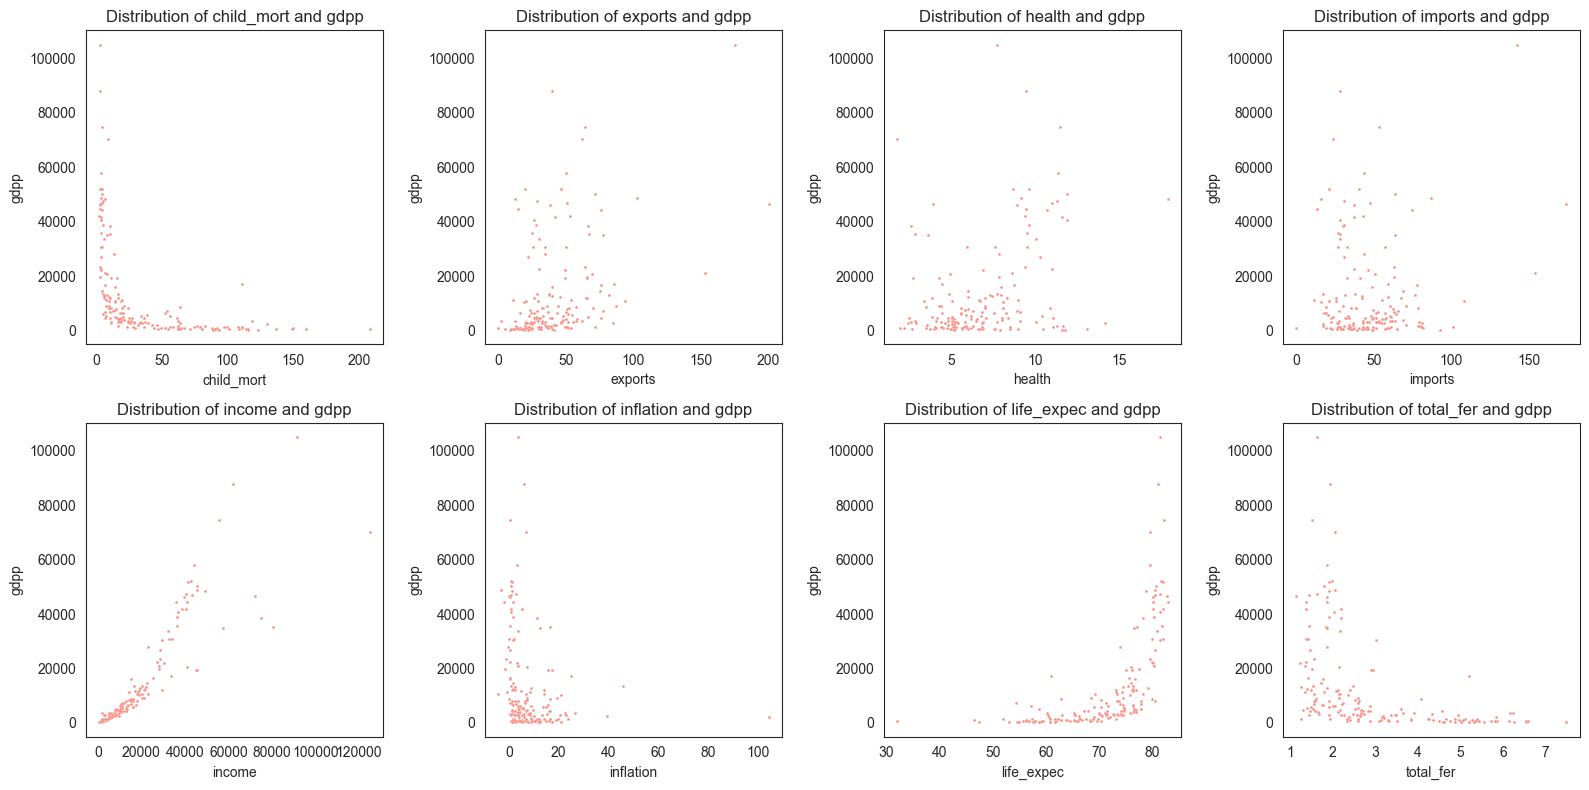

In [108]:
# Explore the continuous independent features against gdpp using scatter plots.
features_in_scatter_plots(df, "gdpp", "salmon")

The distributions of income and gdpp are very similar in shape, and the heatmap also found a relationship between them. 

The distribution of income shows a linear increasing trend.

<Figure size 1000x1000 with 0 Axes>

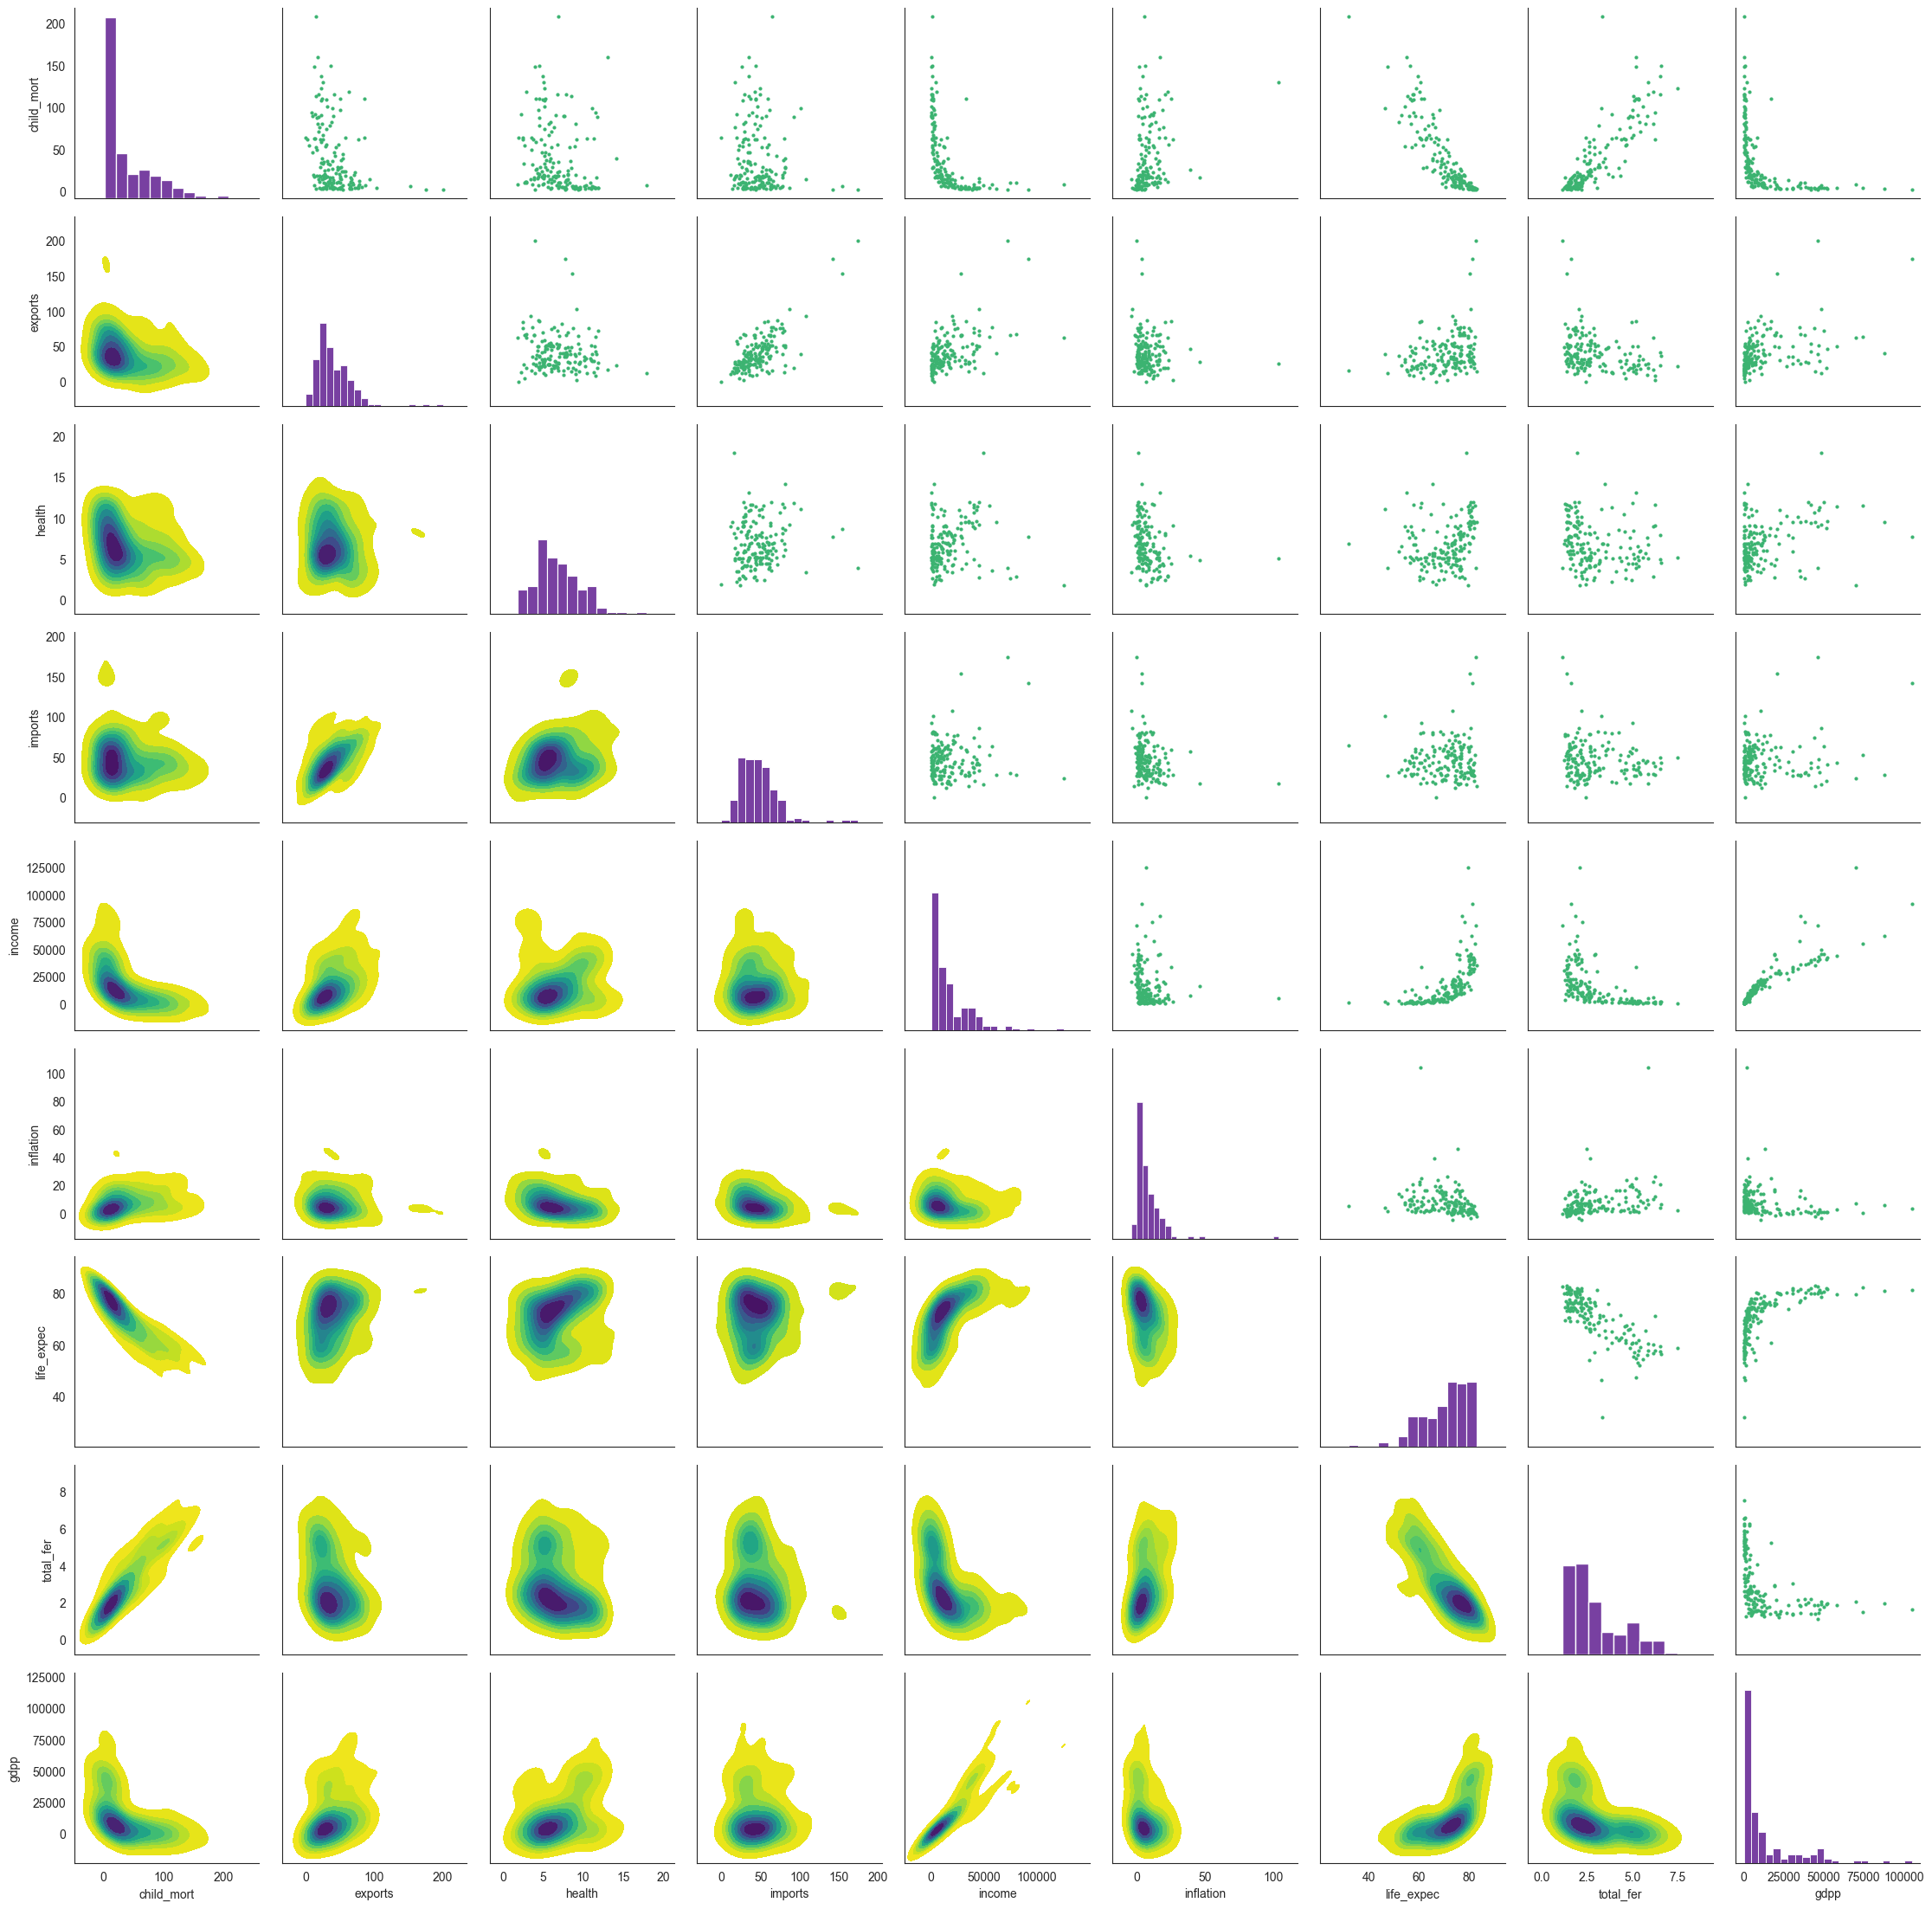

In [109]:
# Create a pair plot
pair_plot(df)

Creating a pair plot is a helpful step in exploring the relationships between features before clustering data. The diagonal plots within a pair plot show the distribution of individual features, which can give insight into how the data is spread for each feature. While distinct peaks in these plots may hint at features with distinct ranges, true separability is better assessed by examining the off-diagonal plots, which show the relationships between pairs of features. These relationships provide a clearer view of how well the data might separate into clusters.

Positive correlations
* total_fer and child_mort
* gdpp and income

Negative correlations
* child_mort and life_expec
* total_fer and life_expec

### Scaling the Data

In [110]:
# Normalise the data using MinMaxScaler
# Convert int64 variables to float64 before scaling
df[["income", "gdpp"]] = df[["income", "gdpp"]].astype(float)

# Normalise the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Convert back to dataframe
df_scaled = pd.DataFrame(scaled, columns=df.columns)

## K-Means Clustering

### Selecting K

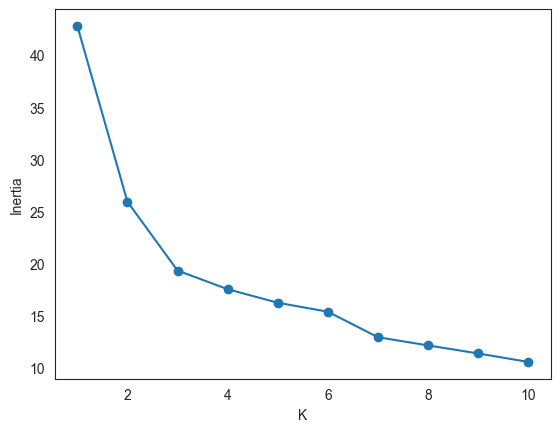

In [111]:
# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

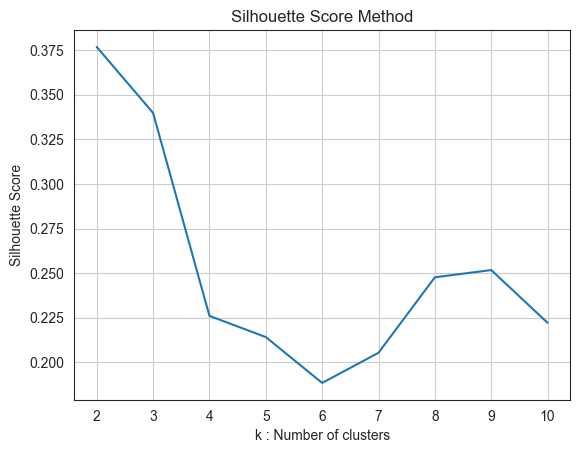

In [112]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)

Based on the elbow and silhouette score method choose a value for K.

The elbow curve indicates K is in the range 3-6. The silhouette score is considerably higher for k = 2 or 3 than for higher numbers of clusters. Combining these facts indicates K = 3.

## Fitting a K-Means Model with the selected K value

In [113]:
# Fitting K-means model
# Remember to set the random_state to rseed
# Initialise KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=47)

# Make predictions
y_pred = kmeans.fit_predict(df_scaled)

# Print score
score = round(
    silhouette_score(df_scaled, kmeans.labels_, metric='euclidean'), 3
)
print(
    f"The silhouette score for the Kmeans cluster model with K = 3 is:"
    f"\n     {score}"
)

The silhouette score for the Kmeans cluster model with K = 3 is:
     0.34


In [114]:
# Count the number of observations in each cluster
cluster_count = np.bincount(kmeans.labels_)
print(f"There are {cluster_count[0]} observations in cluster [0],"
     f"\n          {cluster_count[1]} observations in cluster [1], and"
     f"\n          {cluster_count[2]} observations in cluster [2].")

There are 87 observations in cluster [0],
          35 observations in cluster [1], and
          45 observations in cluster [2].


## Predictions

In [115]:
# Add the predicted cluster label column to the original dataframe
cluster_labels = kmeans.labels_
df_scaled["Cluster_label"] = cluster_labels

## Visualisation of clusters

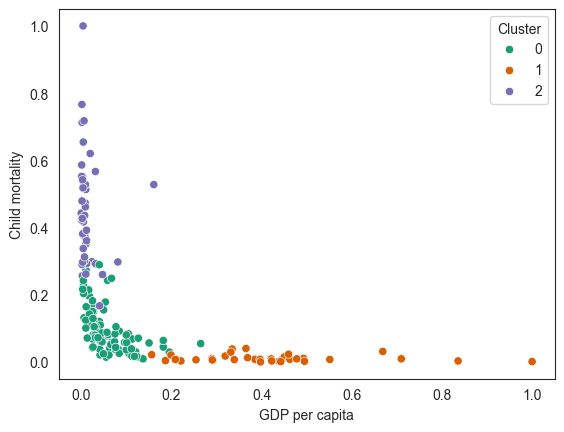

In [116]:
# Visualisation of clusters: child mortality vs gdpp
visualise_clusters(
    df_scaled, x="gdpp", y="child_mort",
    xlabel="GDP per capita", ylabel = "Child mortality"
)

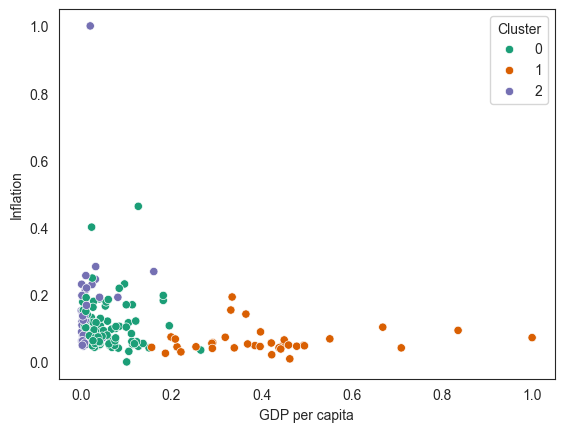

In [117]:
# Visualisation of clusters: inflation vs gdpp
visualise_clusters(
    df_scaled, x="gdpp", y="inflation",
    xlabel="GDP per capita", ylabel = "Inflation"
)

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

- Cluster 0 = developing
- Cluster 1 = developed
- Cluster 2 = least developed

In [118]:
# Create cluster name mapping
cluster_names = {
    0: "Developing",
    1: "Developed",
    2: "Least Developed"
}

# Add cluster names to dataframe
df_scaled["Cluster_name"] = df_scaled["Cluster_label"].map(cluster_names)

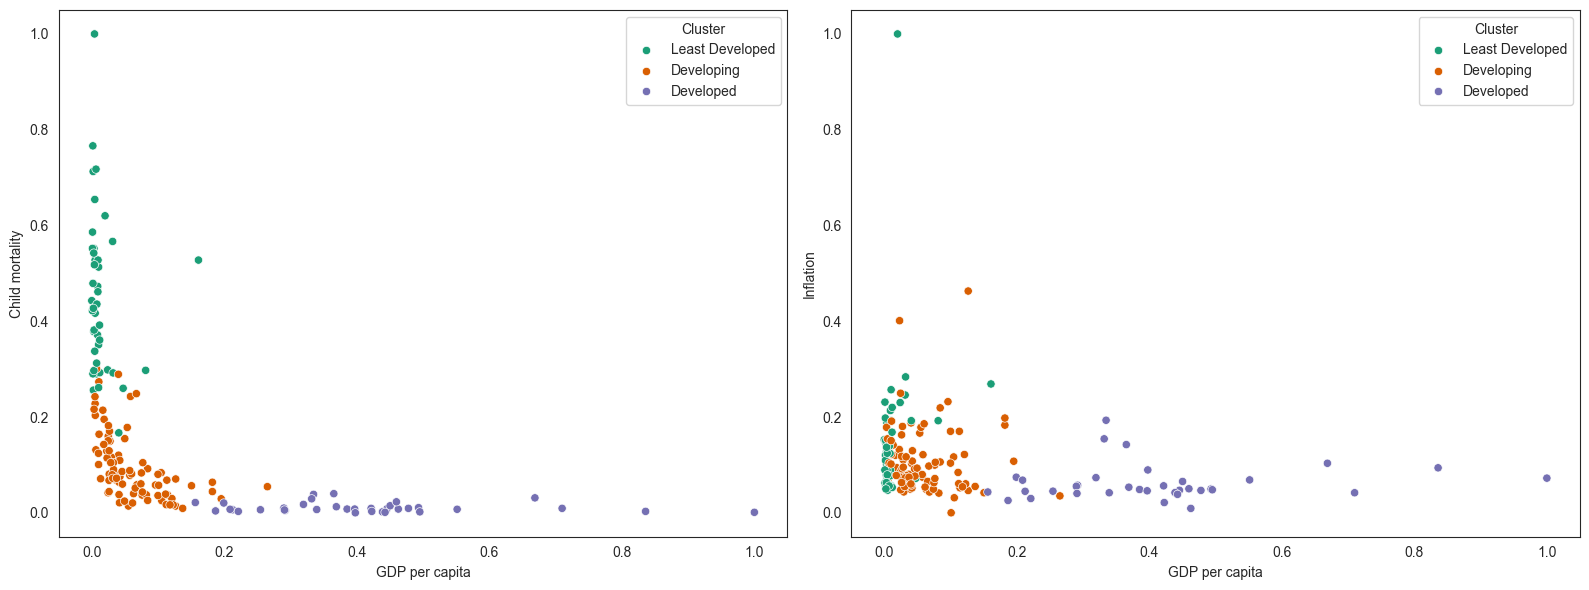

In [119]:
# Combined visualisation: child mortality and inflation vs gdpp side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: child mortality vs gdpp
visualise_clusters(
    df_scaled, x="gdpp", y="child_mort",
    xlabel="GDP per capita", ylabel="Child mortality",
    hue="Cluster_name", ax=axes[0]
)

# Right subplot: inflation vs gdpp
visualise_clusters(
    df_scaled, x="gdpp", y="inflation",
    xlabel="GDP per capita", ylabel="Inflation",
    hue="Cluster_name", ax=axes[1]
)

plt.tight_layout()

In [120]:
# Add country names back in to dataframe
df_scaled['country'] = df_all['country']

In [122]:
# Create lists of the countries in each cluster and display in a table.
order = ["Least Developed", "Developing", "Developed"]
cluster_countries = (
    df_scaled[["Cluster_name", "country"]]
    .sort_values(["Cluster_name", "country"])
    .groupby("Cluster_name")["country"]
    .apply(list)
    .reindex(order)
)

cluster_table = cluster_countries.to_frame(name="Countries")
cluster_table["Count"] = cluster_table["Countries"].apply(len)
cluster_table["Countries"] = cluster_table["Countries"].apply(
    lambda xs: ", ".join(xs)
)

cluster_table = cluster_table.reset_index().rename(
    columns={"Cluster_name": "Cluster Name"}
)
cluster_table = cluster_table[["Cluster Name", "Count", "Countries"]]

styled_table = (
    cluster_table.style
    .set_properties(
        subset=["Countries"], **{"white-space": "normal", "max-width": "720px"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [
            ("text-align", "left"), 
            ("vertical-align", "top")
        ]},
    ])
)

display(styled_table)

,Cluster Name,Count,Countries
0,Least Developed,45,"Afghanistan, Angola, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Equatorial Guinea, Eritrea, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Iraq, Kenya, Kiribati, Lao, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mozambique, Namibia, Niger, Nigeria, Pakistan, Rwanda, Senegal, Sierra Leone, Sudan, Tanzania, Timor-Leste, Togo, Uganda, Yemen, Zambia"
1,Developing,87,"Albania, Algeria, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belize, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Cambodia, Cape Verde, Chile, China, Colombia, Costa Rica, Croatia, Dominican Republic, Ecuador, Egypt, El Salvador, Estonia, Fiji, Georgia, Grenada, Guatemala, Guyana, Hungary, India, Indonesia, Iran, Jamaica, Jordan, Kazakhstan, Kyrgyz Republic, Latvia, Lebanon, Libya, Lithuania, Macedonia, FYR, Malaysia, Maldives, Mauritius, Micronesia, Fed. Sts., Moldova, Mongolia, Montenegro, Morocco, Myanmar, Nepal, Oman, Panama, Paraguay, Peru, Philippines, Poland, Romania, Russia, Samoa, Saudi Arabia, Serbia, Seychelles, Solomon Islands, South Africa, Sri Lanka, St. Vincent and the Grenadines, Suriname, Tajikistan, Thailand, Tonga, Tunisia, Turkey, Turkmenistan, Ukraine, Uruguay, Uzbekistan, Vanuatu, Venezuela, Vietnam"
2,Developed,35,"Australia, Austria, Belgium, Brunei, Canada, Cyprus, Czech Republic, Denmark, Finland, France, Germany, Greece, Iceland, Ireland, Israel, Italy, Japan, Kuwait, Luxembourg, Malta, Netherlands, New Zealand, Norway, Portugal, Qatar, Singapore, Slovak Republic, Slovenia, South Korea, Spain, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States"
